# How to Evaluate and Build a Deep Research Agent with o3 and 4o

This notebook shows how to create a finance research agent and is heavily inspired by the [Plan-and-Solve](https://arxiv.org/abs/2305.04091) and examples from Langgraph.

The core idea is to first come up with a multi-step plan, and then go through that plan one item at a time. 
After accomplishing a particular task, you can then revisit the plan and modify as appropriate.


The general computational graph looks like the following:

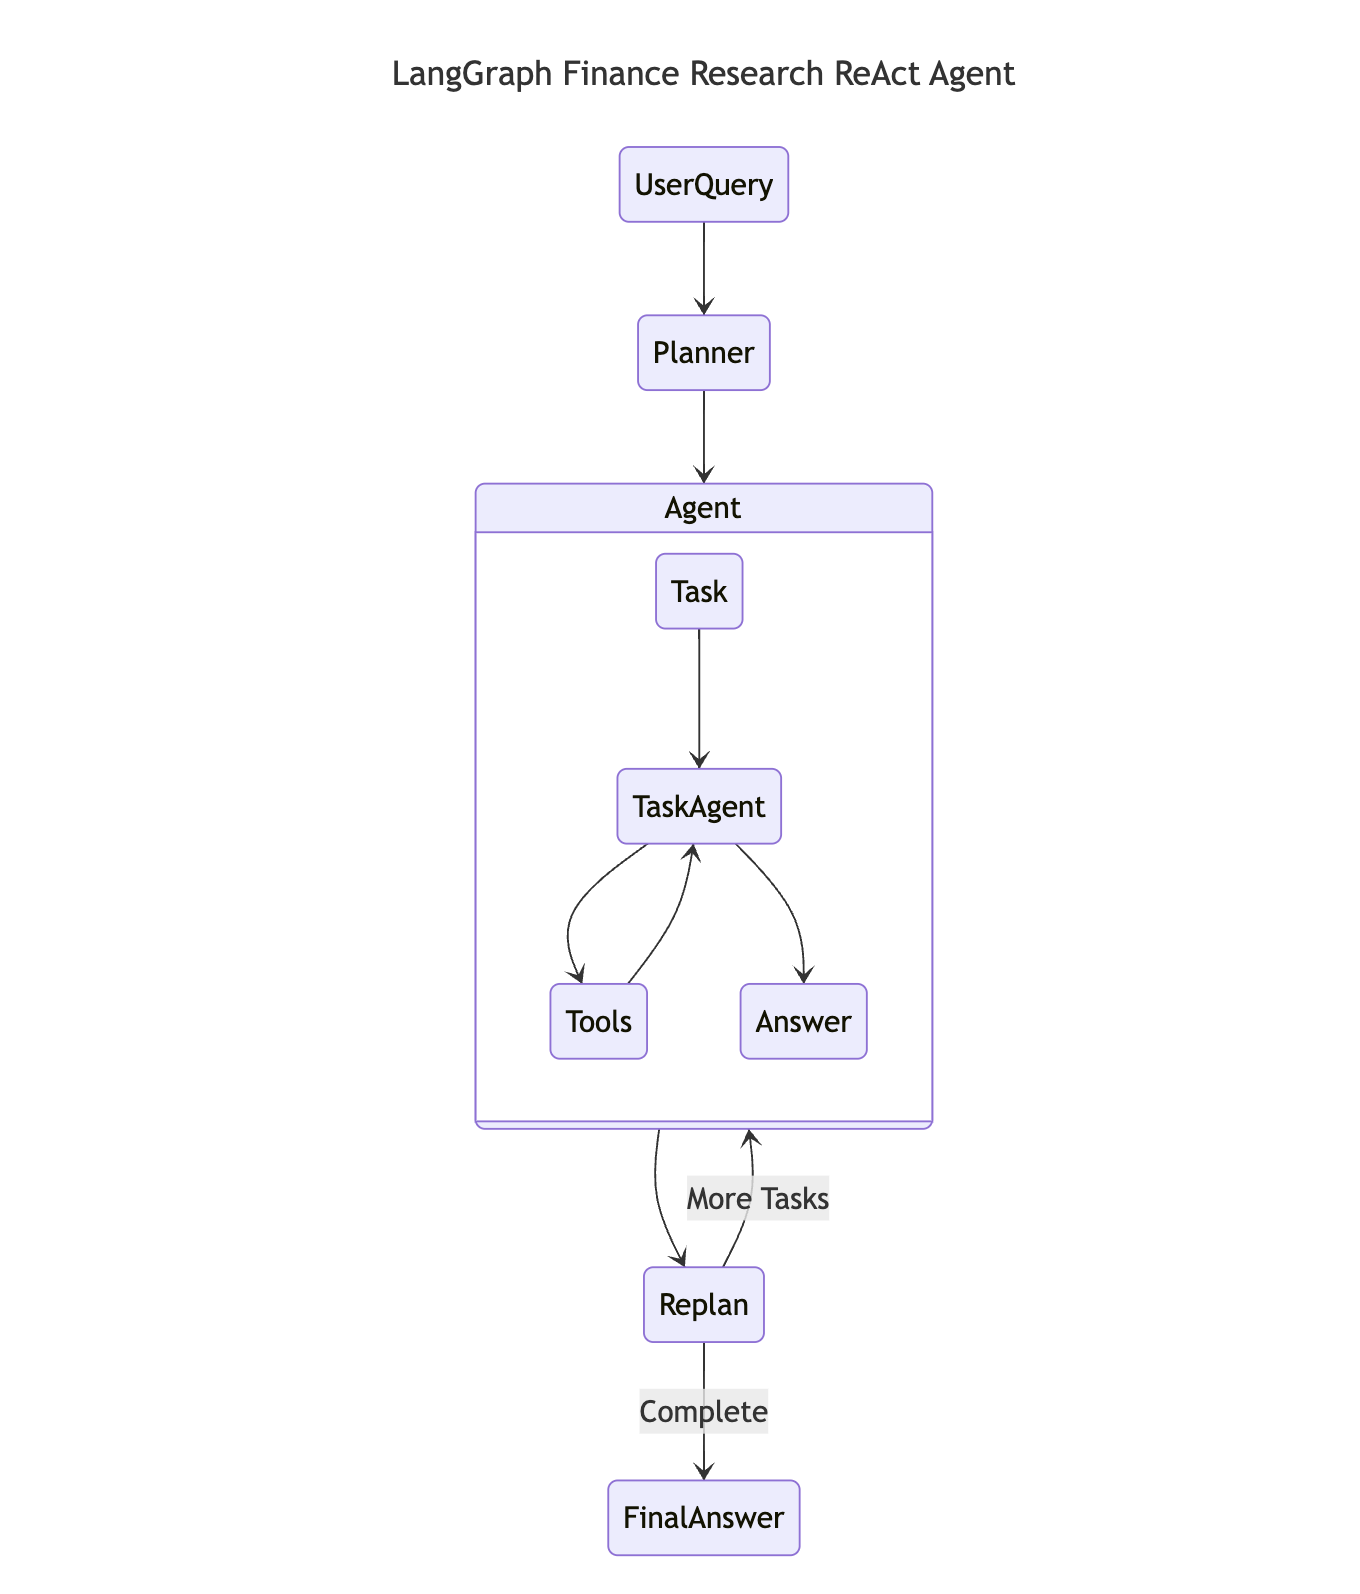


This compares to a typical [ReAct](https://arxiv.org/abs/2210.03629) style agent where you think one step at a time.
The advantages of this "plan-and-execute" style agent are:

1. Explicit long term planning (which even really strong LLMs can struggle with)
2. Ability to use smaller/weaker models for the execution step, only using larger/better models for the planning step

## Setup

First, we need to install the packages required.

In [ ]:
# %%capture --no-stderr
%pip install --quiet -U langgraph==0.2.56 langchain-community==0.3.9 langchain-openai==0.2.11 tavily-python==0.5.0 promptquality==0.72.1

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [ ]:
import os
from dotenv import load_dotenv

import promptquality as pq

load_dotenv()
pq.login("console.demo.rungalileo.io")

## Define our Execution Agent

Now we will create the execution agent we want to use to execute tasks. 
Note that for this example, we will be using the same execution agent for each task, but this doesn't HAVE to be the case.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
system_prompt = "You are a helpful finance expert named Fred in year 2024. First of all you create a plan to get answer to the research query. Then you use tools to get answers to the questions. Use the perplexity tool to get analysis from web, tavily to get web search and repl for any math calculations. Finally you use the answers to each question in the plan to give your final verdict."

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="o3-mini")

# choose the tools that will be used by the agent
tools = [TavilySearchResults(max_results=3)]

# tools = [ask_perplexity]
# tools = [ask_perplexity, TavilySearchResults(max_results=3), repl_tool]

agent_executor = create_react_agent(llm, tools, state_modifier=system_prompt)
agent_executor.invoke({"messages": [("user", "what is the latest info on nasdaq")]})

## Define New Tools

We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily. However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/how_to/custom_tools) on how to do that.

In [ ]:
from langchain_experimental.utilities import PythonREPL
from langchain_community.chat_models import ChatPerplexity
from langchain import PromptTemplate
from langchain_core.tools import tool
from langchain.agents import Tool

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

perplexity_llm = ChatPerplexity(
    temperature=0, model="llama-3.1-sonar-large-128k-online"
)

perplexity_prompt = PromptTemplate(
    template="""Given the following overall question `{input}`.

    Perform the task by understanding the problem, extracting variables, and being smart
    and efficient. Write a detailed response that address the task.
    When confronted with choices, make a decision yourself with reasoning.
    """,
    input_variables=["input"],
)

pplx_chain = perplexity_prompt | perplexity_llm 

@tool
def ask_perplexity(query):
    """
    Fetches relevant info from the internet based on the user query and be to the point. Answer in as short as possible.

    Args:
        query (str): A string that represents the user query.

    Returns:
        str: A string that represents the relevant information fetched from the internet.
    """
    return pplx_chain.invoke(query)

pplx_chain.invoke("what is the size of funding of series B for galileo")

## Define the State

Let's now start by defining the state the track for this agent.

First, we will need to track the current plan. Let's represent that as a list of strings.

Next, we should track previously executed steps. Let's represent that as a list of tuples (these tuples will contain the step and then the result)

Finally, we need to have some state to represent the final response as well as the original input.

In [5]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## Planning Step

Let's now think about creating the planning step. This will use function calling to create a plan.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [6]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [7]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a finance research agent working in Oct 2024. For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. Do a thorough analysis on risks, competition and market share. Try to find stock price forecast info for 1, 3 and 5 year.\
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps. At the end use the info collected to give the final answer to the main question containing the facts.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="o3-mini").with_structured_output(Plan)

In [ ]:
planner.invoke(
    {
        "messages": [
            ("user", "Should we invest in Tesla given the current situation of EV?")
        ]
    }
)

## Re-Plan Step

Now, let's create a step that re-does the plan based on the result of the previous step.

In [9]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="o3-mini", temperature=0
).with_structured_output(Act)

## Create the Graph

We can now create the graph!

In [10]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [11]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [13]:
context_adherence_scorer = pq.CustomizedChainPollScorer(
                        scorer_name=pq.CustomizedScorerName.context_adherence_plus,
                        model_alias=pq.Models.gpt_4o,
                        num_judges=3)

tool_selection_scorer = pq.CustomizedChainPollScorer(
                scorer_name=pq.CustomizedScorerName.tool_selection_quality,
                model_alias=pq.Models.gpt_4o,
            )

evaluate_handler = pq.GalileoPromptCallback(project_name='deep-research-agent', run_name='v1', scorers=[pq.Scorers.tool_errors_plus, tool_selection_scorer, context_adherence_scorer])

config = {"recursion_limit": 40, "callbacks": [evaluate_handler]}

In [ ]:
queries = [
    "Using Tesla's quarterly revenue data from Q1 2021 to Q4 2023, compare revenue growth rates against automotive industry average",
    "Calculate Microsoft's cloud computing revenue CAGR from Q1 2019 to Q4 2023 based on Azure segment reporting",
    "Analyze Netflix's quarterly subscriber growth rates and content spending correlation from Q1 2020 to Q4 2023",
    "Analyze Disney+'s subscriber growth rate and average revenue per user trends from Q4 2019 launch through Q4 2023",
    "Compute Procter & Gamble's gross margin trends across reported business segments from FY 2019 to FY 2023",
    "Calculate Bank of America's net interest margin trends compared to federal funds rate changes from Q1 2020 to Q4 2023",
    "Analyze Nike's inventory turnover ratio trends from Q1 2019 to Q4 2023 using quarterly filings",
    "Compare Costco's membership fee revenue growth with store count expansion from FY 2018 to FY 2023",
    "Calculate Home Depot's sales per square foot trends using annual report data from 2019 to 2023",
    "Analyze Salesforce's revenue per employee metrics compared to other software companies from FY 2020 to FY 2024",
]


for query in queries[:3]:
    print(f"Query: {query}")
    async for event in app.astream({"input": query}, config=config):
        for k, v in event.items():
            if k != "__end__":
                print(v)
            
evaluate_handler.finish()